## Import Python Modules

In [ ]:
# Group 5
# Neel Gandhi, Sunishka Jain, Daniel Shen, Julian Wu

# Imports
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 

## Import data


In [ ]:

# file = './clinvar_conflicting.csv'
file = './processedData.csv'
# file = './processedData01.csv'

data = pd.read_csv(file)

In [ ]:

data.columns

Index(['Unnamed: 0', 'CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC',
       'AF_TGP', 'CLNVC', 'CLASS', 'IMPACT', 'SYMBOL', 'cDNA_position',
       'CDS_position', 'Protein_position', 'STRAND', 'SIFT', 'PolyPhen',
       'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'Amino_acid_ref', 'Amino_acid_alt',
       'unknown', 'germline', 'somatic', 'inherited', 'paternal', 'maternal',
       'de-novo', 'biparental', 'uniparental', 'not-tested',
       'tested-inconclusive', 'other_origin', 'missense_variant',
       'synonymous_variant', 'other', 'IE', 'IELOCATION',
       'has_Hereditary_cancer-predisposing_syndrome',
       'has_Hereditary_breast_and_ovarian_cancer_syndrome',
       'has_Familial_cancer_of_breast', 'has_Dilated_cardiomyopathy_1G',
       'has_Limb-girdle_muscular_dystrophy,_type_2J',
       'has_Cardiovascular_phenotype', 'has_Hypertrophic_cardiomyopathy',
       'has_Ataxia-telangiectasia_syndrome',
       'has_Hereditary_nonpolyposis_colon_cancer',
       'has_Dilated_Cardiomyo

In [ ]:
import numpy as np

from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
convert_feature = ['cDNA_position','CDS_position','Protein_position']
data['cDNA_position'] = data['cDNA_position'].astype(str).str.replace(r'\D+', '')
data['CDS_position'] = data['CDS_position'].astype(str).str.replace(r'\D+', '')
data['Protein_position'] = data['Protein_position'].astype(str).str.replace(r'\D+', '')
for i in range(len(convert_feature)):
  data[convert_feature[i]] = data[convert_feature[i]].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


## Splitting Dataset

In [ ]:
cancer = data

X = data.drop(columns=['CLASS'])
y = data['CLASS']

In [ ]:
#Before we split into training and testing, we need to tinker around with some under-sampling of the
#no conflict class
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X, y = rus.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import train_test_split
#
# Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [ ]:
df_accur_roc_score = pd.DataFrame(columns=['Roc_Auc_Score'])

## XGBoost Classifer

[[2473 1324]
 [1052 2746]]


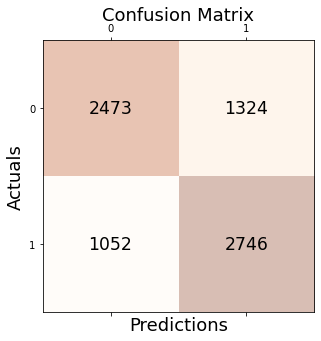

True Positives: 2746
True Negatives: 2473
False Positives: 1324
False Negatives: 1052
--------------------------------------------------
Accuracy: 0.69
Mis-Classification: 0.31
Sensitivity: 0.72
Specificity: 0.65
Precision: 0.65
f_1 Score: 0.69


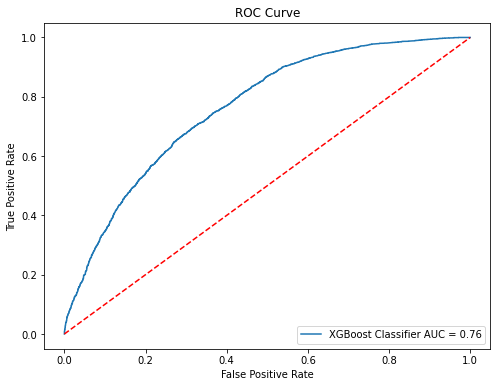

In [ ]:


xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = xgb_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['XGBoost_Classifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='XGBoost Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Logistic Regression

[[  99 3698]
 [  50 3748]]


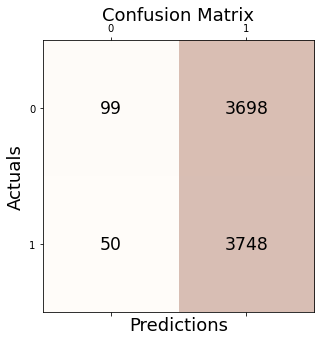

True Positives: 3748
True Negatives: 99
False Positives: 3698
False Negatives: 50
--------------------------------------------------
Accuracy: 0.51
Mis-Classification: 0.49
Sensitivity: 0.99
Specificity: 0.03
Precision: 0.03
f_1 Score: 0.05


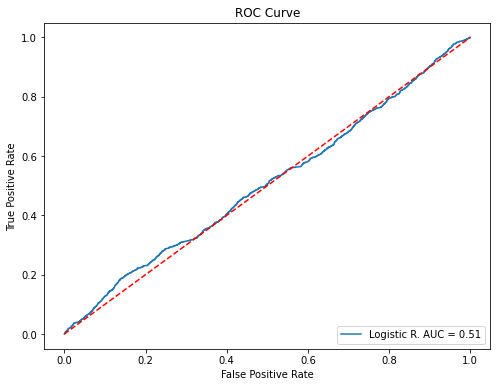

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=0).fit(X_train,y_train)
y_pred = lr_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()



confusion_metrics(conf_matrix)



y_preds = lr_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['Logistic_regression'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Logistic R. AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Decision Tree Classifer


[[2400 1397]
 [1434 2364]]


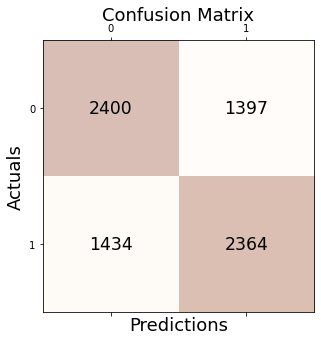

True Positives: 2364
True Negatives: 2400
False Positives: 1397
False Negatives: 1434
--------------------------------------------------
Accuracy: 0.63
Mis-Classification: 0.37
Sensitivity: 0.62
Specificity: 0.63
Precision: 0.63
f_1 Score: 0.63


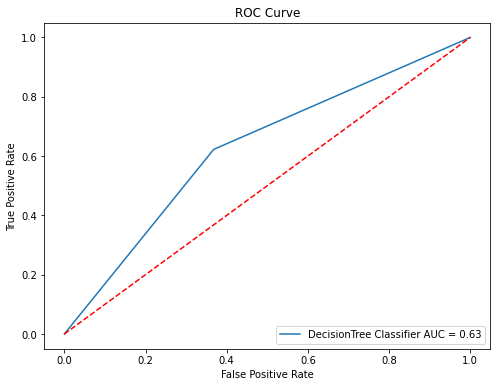

In [ ]:
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
dt_model = tree.DecisionTreeClassifier()
dt_model = dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = dt_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['DecisionTreeClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='DecisionTree Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


## Random Forest Classifier

[[2676 1121]
 [1335 2463]]


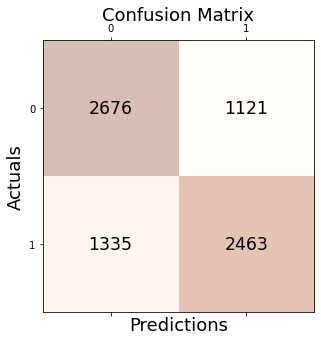

True Positives: 2463
True Negatives: 2676
False Positives: 1121
False Negatives: 1335
--------------------------------------------------
Accuracy: 0.68
Mis-Classification: 0.32
Sensitivity: 0.65
Specificity: 0.7
Precision: 0.7
f_1 Score: 0.68


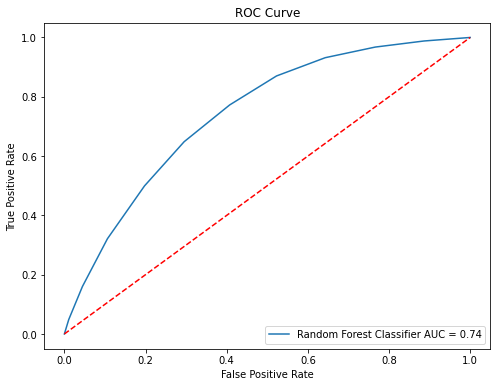

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf_model = RandomForestClassifier(n_estimators = 10, random_state = 0)
rf_model = rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = rf_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['RandomForestClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Random Forest Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


## K Nearest Neighbours

[[2026 1771]
 [1497 2301]]


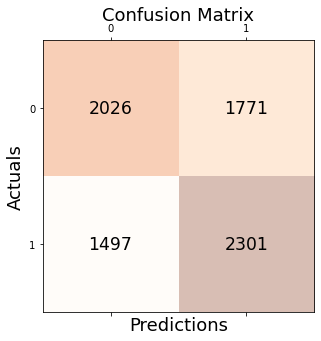

True Positives: 2301
True Negatives: 2026
False Positives: 1771
False Negatives: 1497
--------------------------------------------------
Accuracy: 0.57
Mis-Classification: 0.43
Sensitivity: 0.61
Specificity: 0.53
Precision: 0.53
f_1 Score: 0.57


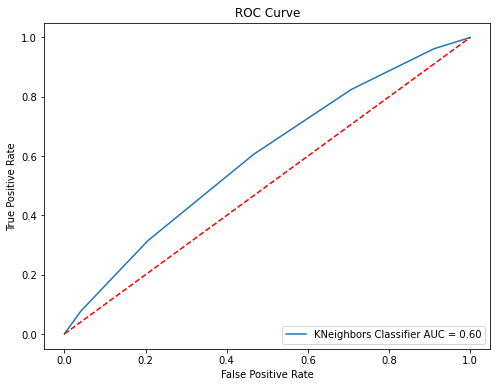

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')
neigh =  neigh.fit(X_train,y_train)
y_pred = neigh.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = neigh.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['KNeighborsClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='KNeighbors Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## AdaBoost Classifer

[[2496 1301]
 [1126 2672]]


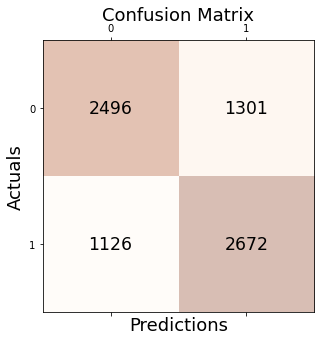

True Positives: 2672
True Negatives: 2496
False Positives: 1301
False Negatives: 1126
--------------------------------------------------
Accuracy: 0.68
Mis-Classification: 0.32
Sensitivity: 0.7
Specificity: 0.66
Precision: 0.66
f_1 Score: 0.68


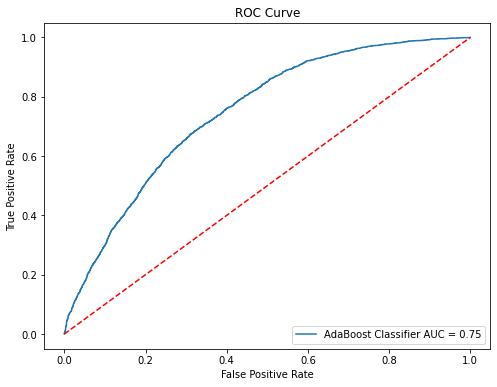

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf =  clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['AdaBoostClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AdaBoost Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Gradient Boost

[[2532 1265]
 [1125 2673]]


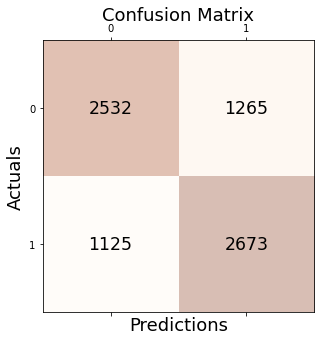

True Positives: 2673
True Negatives: 2532
False Positives: 1265
False Negatives: 1125
--------------------------------------------------
Accuracy: 0.69
Mis-Classification: 0.31
Sensitivity: 0.7
Specificity: 0.67
Precision: 0.67
f_1 Score: 0.68


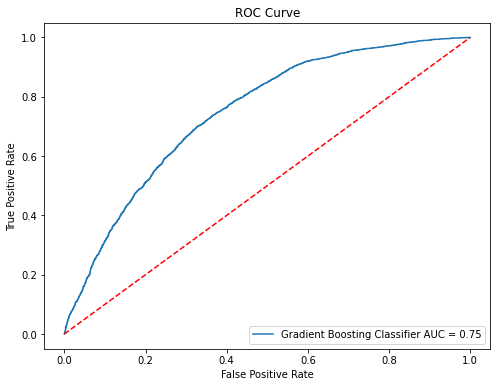

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['GradientBoostingClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Gradient Boosting Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Support Vector Machine

[[1934 1863]
 [ 712 3086]]


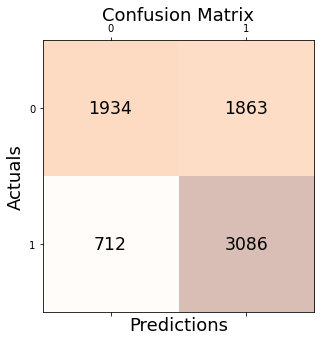

True Positives: 3086
True Negatives: 1934
False Positives: 1863
False Negatives: 712
--------------------------------------------------
Accuracy: 0.66
Mis-Classification: 0.34
Sensitivity: 0.81
Specificity: 0.51
Precision: 0.51
f_1 Score: 0.63


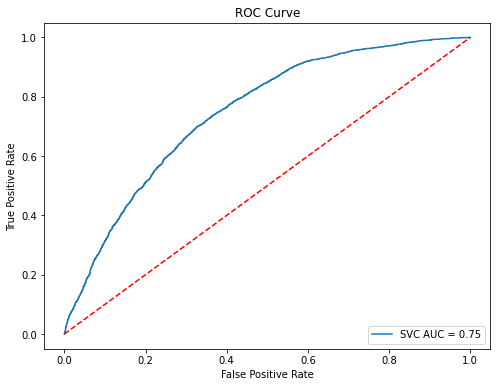

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
svm_model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_model.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['SVC'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='SVC AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Gaussian Naive Bayes

[[3789    8]
 [3794    4]]


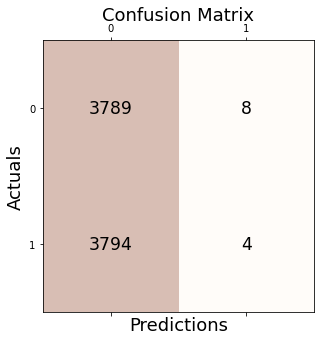

True Positives: 4
True Negatives: 3789
False Positives: 8
False Negatives: 3794
--------------------------------------------------
Accuracy: 0.5
Mis-Classification: 0.5
Sensitivity: 0.0
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.0


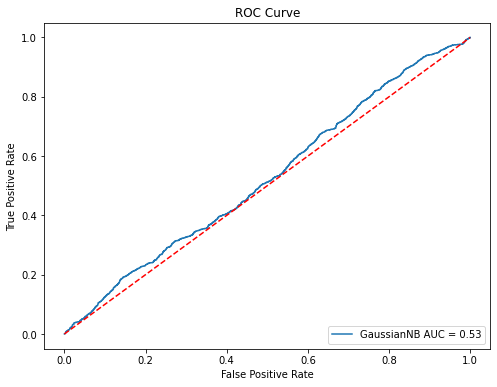

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['GaussianNB'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='GaussianNB AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## SDG Classifier

In [ ]:
# from sklearn.linear_model import SGDClassifier
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
# clf.fit(X_train,y_train)
# y_pred = clf.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

# # Calculate the confusion matrix
# #
# conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
# #
# # Print the confusion matrix using Matplotlib
# #
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()


# confusion_metrics(conf_matrix)

# y_preds = clf.predict_proba(X_test)
# preds = y_preds[:,1]

# fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# auc_score = metrics.auc(fpr, tpr)
# df_accur_roc_score.loc['SGDClassifier'] = [auc_score]

# plt.subplots(figsize=(8, 6))
# plt.title('ROC Curve')
# plt.plot(fpr, tpr, label='SGD Classifier AUC = {:.2f}'.format(auc_score))
# plt.plot([0,1],[0,1],'r--')


# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.legend(loc='lower right')
# plt.show()

## Gaussian Process Classifier

In [ ]:
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# kernel = 1.0 * RBF(1.0)
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=0)
# gpc.fit(X_train,y_train)
# y_pred = gpc.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

# # Calculate the confusion matrix
# #
# conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
# #
# # Print the confusion matrix using Matplotlib
# #
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()


# confusion_metrics(conf_matrix)


# y_preds = clf.predict_proba(X_test)
# preds = y_preds[:,1]

# fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# auc_score = metrics.auc(fpr, tpr)
# df_accur_roc_score.loc['GaussianProcessClassifier'] = [auc_score]

# plt.subplots(figsize=(8, 6))
# plt.title('ROC Curve')
# plt.plot(fpr, tpr, label='Gaussian Process Classifier AUC = {:.2f}'.format(auc_score))
# plt.plot([0,1],[0,1],'r--')


# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.legend(loc='lower right')
# plt.show()

## Linear Discriminant Analysis

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train,y_train)
# y_pred = clf.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

# # Calculate the confusion matrix
# #
# conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
# #
# # Print the confusion matrix using Matplotlib
# #
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()


# confusion_metrics(conf_matrix)

# y_preds = clf.predict_proba(X_test)
# preds = y_preds[:,1]

# fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# auc_score = metrics.auc(fpr, tpr)
# df_accur_roc_score.loc['GaussianProcessClassifier'] = [auc_score]

# plt.subplots(figsize=(8, 6))
# plt.title('ROC Curve')
# plt.plot(fpr, tpr, label='Gaussian Process Classifier AUC = {:.2f}'.format(auc_score))
# plt.plot([0,1],[0,1],'r--')


# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.legend(loc='lower right')
# plt.show()

## Quadratic Discriminant Analysis

In [ ]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# clf = QuadraticDiscriminantAnalysis()
# clf.fit(X_train,y_train)
# y_pred = clf.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

# # Calculate the confusion matrix
# #
# conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
# #
# # Print the confusion matrix using Matplotlib
# #
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()


# confusion_metrics(conf_matrix)

# y_preds = clf.predict_proba(X_test)
# preds = y_preds[:,1]

# fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# auc_score = metrics.auc(fpr, tpr)
# df_accur_roc_score.loc['GaussianProcessClassifier'] = [auc_score]

# plt.subplots(figsize=(8, 6))
# plt.title('ROC Curve')
# plt.plot(fpr, tpr, label='Gaussian Process Classifier AUC = {:.2f}'.format(auc_score))
# plt.plot([0,1],[0,1],'r--')


# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.legend(loc='lower right')
# plt.show()

## Proposed Stacked Ensemble Machine Learning Model


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

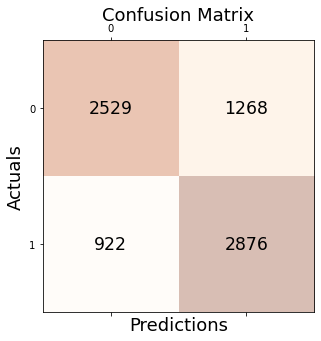

True Positives: 2876
True Negatives: 2529
False Positives: 1268
False Negatives: 922
--------------------------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity: 0.76
Specificity: 0.67
Precision: 0.67
f_1 Score: 0.71


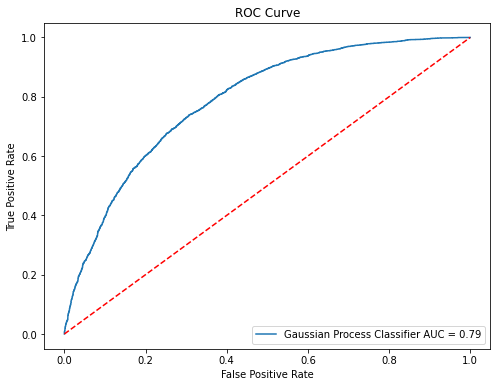

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
estimators = [('rf', RandomForestClassifier(n_estimators = 1000, random_state = 42)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42))),('xgb',xgb.XGBClassifier(objective="binary:logistic", random_state=42))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train).score(X_test, y_test)
y_pred = clf.predict(X_test)
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['GaussianProcessClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Gaussian Process Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Voting Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[0 1 1 ... 0 0 1]


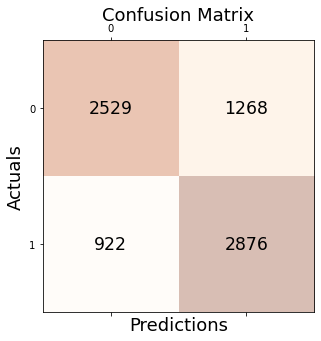

True Positives: 2876
True Negatives: 2529
False Positives: 1268
False Negatives: 922
--------------------------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity: 0.76
Specificity: 0.67
Precision: 0.67
f_1 Score: 0.71


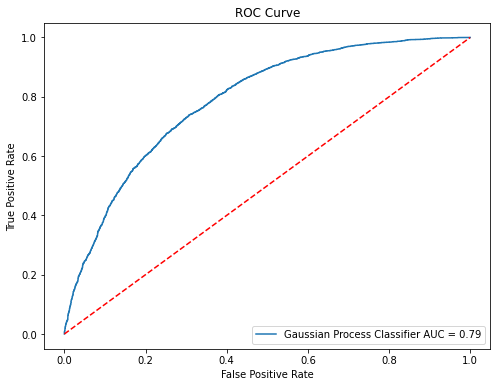

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
clf1 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
clf2 = make_pipeline(StandardScaler(),LinearSVC(random_state=42))
clf3 = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
eclf1 = VotingClassifier(estimators=[('rf', clf1), ('svr', clf2), ('xgb', clf3)], voting='hard')

eclf1 = eclf1.fit(X_train, y_train)
print(eclf1.predict(X_test))
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['GaussianProcessClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Gaussian Process Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

# Explainable AI

## Lime

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 25.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=be5ea42b5ec5b8a99818a42e329107478f8a7d19895f766d718a93ee3b4b8c99
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
data.dropna()

,Unnamed: 0,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNVC,CLASS,...,has_Cardiovascular_phenotype,has_Hypertrophic_cardiomyopathy,has_Ataxia-telangiectasia_syndrome,has_Hereditary_nonpolyposis_colon_cancer,"has_Dilated_Cardiomyopathy,_Dominant",has_Familial_hypercholesterolemia,"has_Breast-ovarian_cancer,_familial_2",has_Familial_adenomatous_polyposis_1,"has_Limb-Girdle_Muscular_Dystrophy,_Recessive",has_Lynch_syndrome
0,6,1,3328358,2,4,0.0000,0.00000,0.0000,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,3328659,4,2,0.1523,0.13103,0.1060,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,1,3347452,3,1,0.0000,0.00357,0.0030,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9,1,5925304,3,1,0.0045,0.00231,0.0058,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,1,5926503,3,1,0.0019,0.00267,0.0010,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50742,65182,23,154157565,4,2,0.0153,0.00473,0.0140,0,0,...,0,0,0,0,0,0,0,0,0,0
50743,65183,23,154158201,2,3,0.0801,0.13923,0.1605,0,0,...,0,0,0,0,0,0,0,0,0,0
50744,65184,23,154159118,4,2,0.0020,0.00060,0.0013,0,1,...,0,0,0,0,0,0,0,0,0,0
50745,65185,23,154194886,4,2,0.0125,0.00370,0.0111,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.drop(['Unnamed: 0'], axis=1)

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNVC,CLASS,IMPACT,...,has_Cardiovascular_phenotype,has_Hypertrophic_cardiomyopathy,has_Ataxia-telangiectasia_syndrome,has_Hereditary_nonpolyposis_colon_cancer,"has_Dilated_Cardiomyopathy,_Dominant",has_Familial_hypercholesterolemia,"has_Breast-ovarian_cancer,_familial_2",has_Familial_adenomatous_polyposis_1,"has_Limb-Girdle_Muscular_Dystrophy,_Recessive",has_Lynch_syndrome
0,1,3328358,2,4,0.0000,0.00000,0.0000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3328659,4,2,0.1523,0.13103,0.1060,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3347452,3,1,0.0000,0.00357,0.0030,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,5925304,3,1,0.0045,0.00231,0.0058,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5926503,3,1,0.0019,0.00267,0.0010,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50742,23,154157565,4,2,0.0153,0.00473,0.0140,0,0,2,...,0,0,0,0,0,0,0,0,0,0
50743,23,154158201,2,3,0.0801,0.13923,0.1605,0,0,2,...,0,0,0,0,0,0,0,0,0,0
50744,23,154159118,4,2,0.0020,0.00060,0.0013,0,1,0,...,0,0,0,0,0,0,0,0,0,0
50745,23,154194886,4,2,0.0125,0.00370,0.0111,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import lime
import lime.lime_tabular

classes = ['benign','malignant']
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.astype(int).values,  
mode='classification',training_labels=y_train,feature_names = X_test.columns.tolist(),class_names=classes)
#Let's take a look for the patient in 100th row
i = 100
exp = explainer.explain_instance(X_train.loc[i,X_test.columns.tolist()].astype(int).values, my_model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


## Permutation Feature Importance

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 24.6 MB/s 
     |████████████████████████████████| 133 kB 91.0 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=5d7eb8cf6f1962f17434093420a9bd0664be27365f0bc6594a7e0d34ce3b3aa1
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
# Calculating and Displaying importance using the eli5 library
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
# Training and fitting a Random Forest Model
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0750 ± 0.0082,AF_EXAC
0.0300 ± 0.0051,AF_TGP
0.0225 ± 0.0019,has_Hereditary_cancer-predisposing_syndrome
0.0201 ± 0.0060,AF_ESP
0.0110 ± 0.0039,LoFtool
0.0087 ± 0.0043,Unnamed: 0
0.0063 ± 0.0028,POS
0.0042 ± 0.0017,CADD_RAW
0.0039 ± 0.0015,IMPACT
0.0034 ± 0.0033,SYMBOL


## SHAP

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 35.3 MB/s 


In [ ]:
# training and fitting a Decision Tree
from sklearn.tree import DecisionTreeClassifier
feature_names = [i for i in data.columns]
tree_model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
row_to_show = 10
data_for_prediction = X_test.iloc[row_to_show] 

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

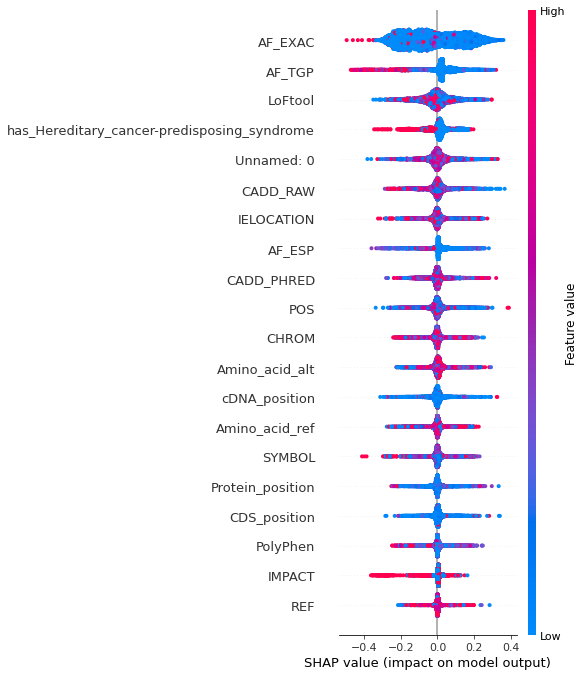

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1],X_test)

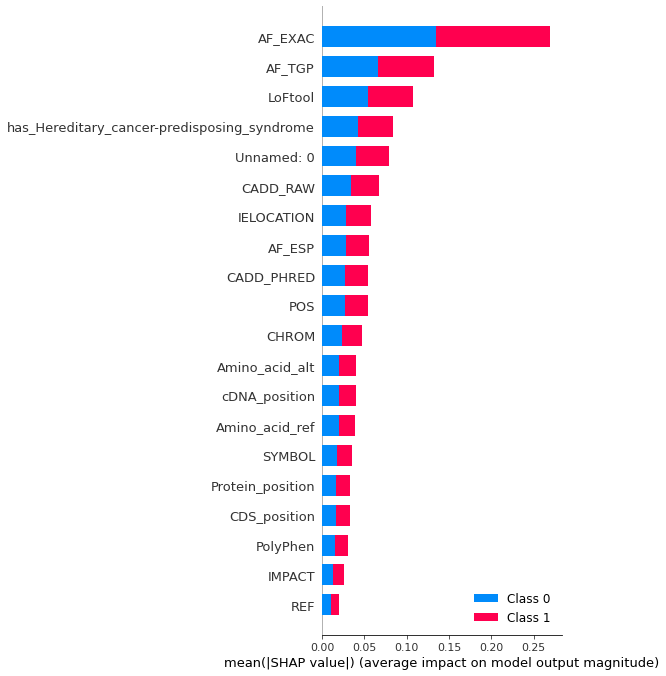

In [ ]:
shap.summary_plot(shap_values, X_test)

## Partial Dependence Plot

In [ ]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 175 kB/s 
     |████████████████████████████████| 13.1 MB 59.0 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=ae42b0ff3ddfea7bb208eaa088f11fa234e6b5ac59703604573351fca4510ab7
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=50f31afadbc0ba173120546d402923c099b33af0e604e51cf56ecbdcb7722d45
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pdpbox sklearn
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


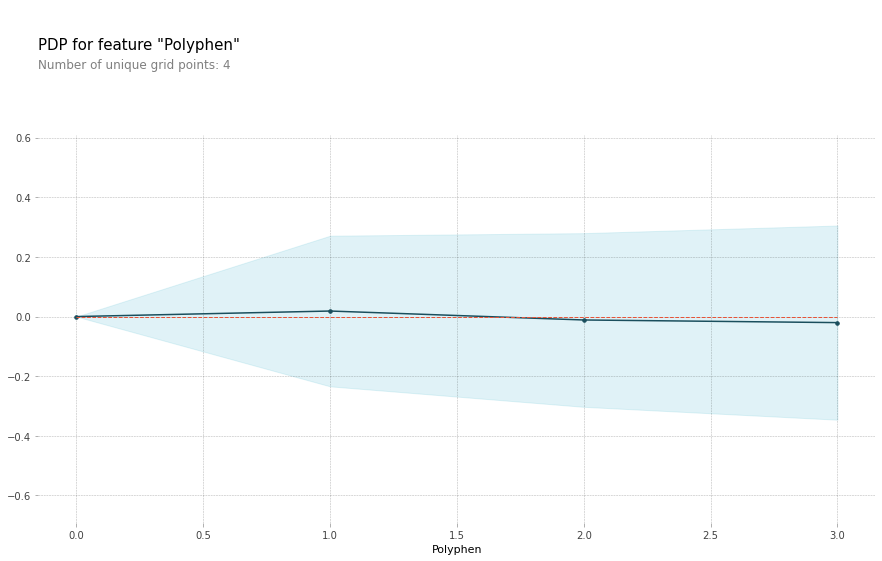

In [ ]:
from pdpbox import pdp, get_dataset, info_plots
feature_names = [i for i in data.columns]

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=X_test.columns.tolist(), feature='PolyPhen')

# plot it
pdp.pdp_plot(pdp_goals, 'Polyphen')
plt.show()

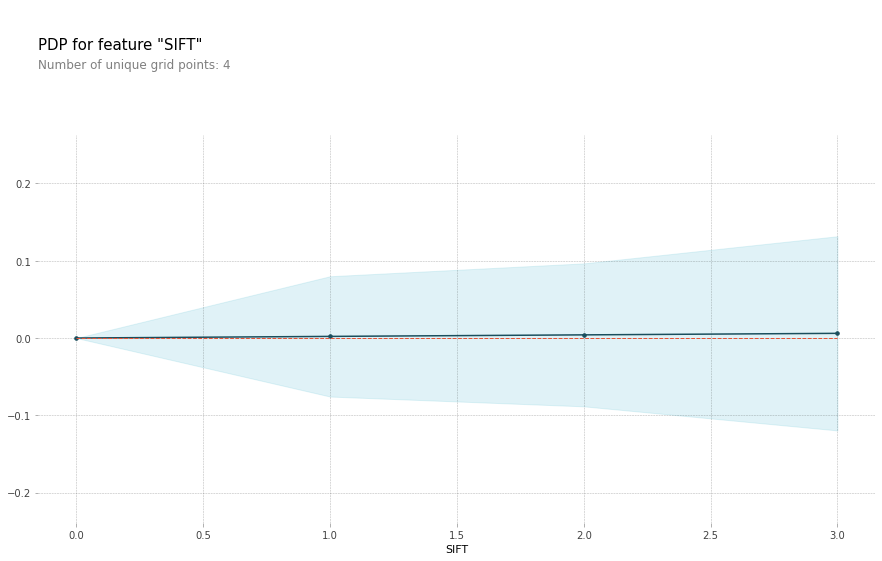

In [ ]:
from pdpbox import pdp, get_dataset, info_plots
feature_names = [i for i in data.columns]

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=X_test.columns.tolist(), feature='SIFT')

# plot it
pdp.pdp_plot(pdp_goals, 'SIFT')
plt.show()

## Feature Importance Distribution

## Feature Interaction

In [ ]:
classes=['0','1']
target=data['CLASS']


In [ ]:
rfc=RandomForestClassifier(random_state=1234)
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=1234)

In [ ]:
rfc.score(X_test,y_test)

0.7099407504937458

In [ ]:
parameters={"n_estimators":[10,20,50,100,200],
           "max_depth":[2,3],
           "min_samples_split":[2,3,4],
           "max_features":('auto','log2'),
           "criterion":('gini','entropy')}
clf=GridSearchCV(rfc, parameters, cv=5)
clf.fit(X_train,y_train)
clf.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
estimator=clf.best_estimator_
estimator.score(X_test,y_test)

0.6708360763660303

In [ ]:
import eli5
# create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(estimator, feature_names=X_test.columns.tolist())
feat_imp_df = feat_imp_df[:10]

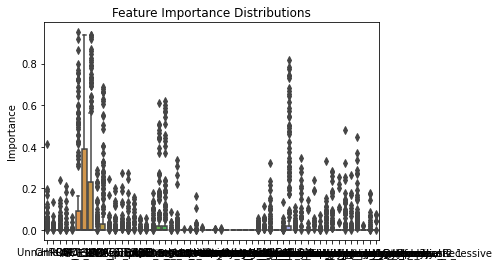

In [ ]:
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=X_test.columns.tolist())

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));